In [2]:
import pickle 
import json 
import matplotlib
import seaborn as sns 
from matplotlib import pyplot as plt
import sklearn 
import pandas as pd 
import os 
from matplotlib.legend_handler import HandlerBase

In [3]:
class MarkerHandler(HandlerBase):
    def create_artists(self, legend, tup,xdescent, ydescent,
                        width, height, fontsize,trans):
        return [plt.Line2D([width/2], [height/2.],ls="",
                       marker=tup[1],color=tup[0], transform=trans)]

In [47]:
# Path to models 
omodel_path = '../models/original'
mmodels_path = '../models/mixed5050/nbins-10'
emodels_path = '../models/everything/nbins-10'

# Path to train data 
otrain_path = '../../data/raw-data'
mtrains_path = '../../data/splitted-data/mixed5050/nbins-10'
etrains_path = '../../data/splitted-data/everything/nbins-10'

with open("feature-clusters.json") as f:
    feature_clusters = json.load(f)

In [48]:
# Only consider m50-1000 models

summary_dict = {"original": {"COF": dict(), "intercept": dict()}, 
                "mix5050": {"COF": dict(), "intercept": dict()},
                "everything": {"COF": dict(), "intercept": dict()}}

targets = ["COF", "intercept"]

for target in targets:
    with open(f'{omodel_path}/{target}.pickle', 'rb') as f:
        summary_dict["original"][target]["model"] = pickle.load(f)
    with open(f'{omodel_path}/{target}.ptxt', 'rb') as f:
        summary_dict["original"][target]["features"] = pickle.load(f)
    summary_dict["original"][target]["traindf"] = pd.read_csv(f"{otrain_path}/original-100.csv")

    for i in range(5):
        if i == 0: 
            summary_dict["mix5050"][target]["models"] = list()
            summary_dict["mix5050"][target]["features"] = list()
            summary_dict["mix5050"][target]["traindf"] = list()
            
            summary_dict["everything"][target]["models"] = list()
            summary_dict["everything"][target]["features"] = list()
            summary_dict["everything"][target]["traindf"] = list() 
            
        with open(f'{mmodels_path}/set_{i}/{target}_1000.pickle', 'rb') as f:
            summary_dict["mix5050"][target]["models"].append(pickle.load(f))
        with open(f'{mmodels_path}/set_{i}/{target}_1000.ptxt', 'rb') as f:
            summary_dict["mix5050"][target]["features"].append(pickle.load(f))
        summary_dict["mix5050"][target]["traindf"].append(pd.read_csv(f"{mtrains_path}/set_{i}/{target}_1000.csv", index_col=0))
            
        with open(f'{emodels_path}/set_{i}/{target}_1000.pickle', 'rb') as f:
            summary_dict["everything"][target]["models"].append(pickle.load(f))
        with open(f'{emodels_path}/set_{i}/{target}_1000.ptxt', 'rb') as f:
            summary_dict["everything"][target]["features"].append(pickle.load(f))
        summary_dict["everything"][target]["traindf"].append(pd.read_csv(f"{etrains_path}/set_{i}/{target}_1000.csv", index_col=0))
        
            
            

In [49]:
# Define meta data
mod_clusters = dict()
for cluster in feature_clusters:
    for feature in feature_clusters[cluster]:
        if feature == 'hbonds':
            mod_clusters[feature] = cluster
        else:
            mod_clusters[feature+'-mean']= cluster
            mod_clusters[feature+'-min']= cluster
            

cats = feature_clusters.keys()
cats_color = {'complexity': 'black',
             'qdist': 'yellow',
             'shape': 'blue',
             'size': 'red'}
cats_marker = {'complexity': 'd',
               'qdist': 'o',
               'shape': '^',
               'size': 's'}


In [58]:
feature_importances_dict = dict()
for trainset in ["original", "mix5050", "everything"]:
    feature_importances_dict[trainset] = dict()
    for target in ["COF", "intercept"]:
        feature_importances_dict[trainset][target] = list()
        if trainset == "original": 
            features = summary_dict[trainset][target]["features"]
            model = summary_dict[trainset][target]["model"]
            traindf = summary_dict[trainset][target]["traindf"]
            tmp_dict = {"name": features,
                        "value": model.feature_importances_.tolist(),
                        "color": [cats_color[mod_clusters[feature]] for feature in features],
                        "marker": [cats_marker[mod_clusters[feature]] for feature in features], 
                        "corr": [traindf.corr().at[target, feature] for feature in features]}
            tmp_df = pd.DataFrame(tmp_dict)
            tmp_df.sort_values(by='value', 
                               inplace=True)
            feature_importances_dict[trainset][target].append(tmp_df)
        else:
            for i in range(5):
                features = summary_dict[trainset][target]["features"][i]
                model = summary_dict[trainset][target]["models"][i]
                traindf = summary_dict[trainset][target]["traindf"][i]
                tmp_dict = {"name": features, 
                            "value": model.feature_importances_.tolist(), 
                            "color": [cats_color[mod_clusters[feature]] for feature in features], 
                            "marker": [cats_marker[mod_clusters[feature]] for feature in features], 
                            "corr": [traindf.corr().at[target, feature] for feature in features]}
                tmp_df = pd.DataFrame(tmp_dict)
                tmp_df.sort_values(by="value", 
                                   inplace=True)
                feature_importances_dict[trainset][target].append(tmp_df)
            


In [137]:
from copy import deepcopy
import seaborn as sns

In [150]:
concat_df = dict()

for target in ["COF", "intercept"]:
    tmp_concat_df = pd.DataFrame(columns=["name", "color", "marker", "value", "corr"])
    for trainset in ["original", "mix5050", "everything"]: 
        tmp_df = deepcopy(feature_importances_dict[trainset][target][0])
        tmp_df["trainset"] = trainset
        tmp_concat_df = pd.concat([tmp_concat_df, tmp_df], ignore_index=True)
    concat_df[target] = tmp_concat_df

In [147]:
merge_df = dict()

for target in ["COF", "intercept"]:
    tmp_concat_df = pd.DataFrame(columns=["name", "color", "marker"])
    for trainset in ["original", "mix5050", "everything"]: 
        tmp_df = deepcopy(feature_importances_dict[trainset][target][0])
        tmp_df.rename(columns={"value": f"{trainset}-value",
                               "corr": f"{trainset}-corr"},
                      inplace=True)
        tmp_merge_df = tmp_concat_df.merge(tmp_df, how="outer", on=["name", "color", "marker"])
    merge_df[target] = tmp_merge_df

COF


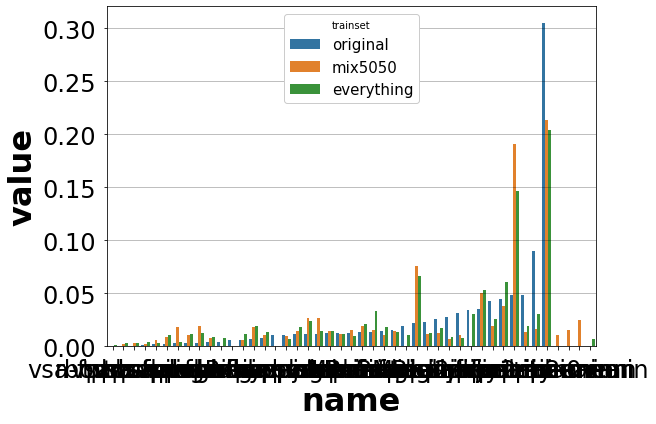

intercept


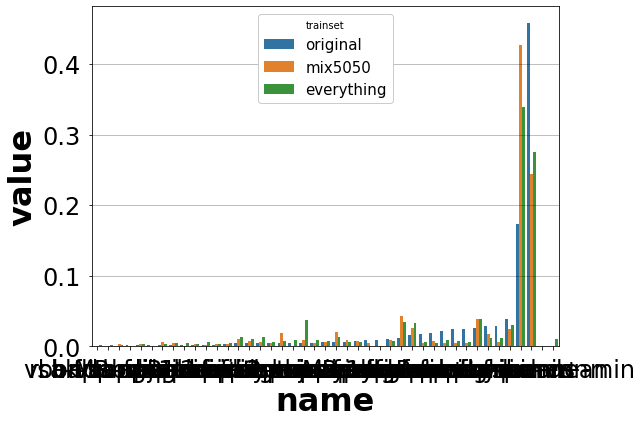

In [154]:
for target in ["COF", "intercept"]:
    print(target)
    plotting_df 
    plt.figure(figsize=(9, 6))
    sns.barplot(x="name", hue="trainset", y="value", data=concat_df[target])
    plt.show()